<a href="https://colab.research.google.com/github/huyphuong99/Car-Number-Plate-Detection-OpenCV-Python/blob/master/CRNN_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/data
!mkdir ./data/file_padding
!cp /content/drive/MyDrive/tima/recognition_OCR/Data/{data}.zip /content/data
!unzip /content/data/{data}.zip -d /content/data 

In [197]:
!mkdir /content/data
!cp /content/drive/MyDrive/WorkTima/NAME.zip /content/data

mkdir: cannot create directory ‘/content/data’: File exists
cp: cannot stat '/content/drive/MyDrive/WorkTima/NAME.zip': No such file or directory
Archive:  /content/data/NAME.zip
replace /content/data/NAME/724_1_THỊ.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
 
from pathlib import Path
from collections import Counter
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import pandas as pd
import cv2 as cv

# Prepare data

In [10]:
batch_size = 16
img_height = 50
img_width = 100
max_len = 7

In [12]:
data = "NAME"

NULL_CHAR = '<nul>'
characters = "aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ"
characters = characters.upper() # Chỉ lấy chữ viết hoa vì trong tập dữ liệu họ tên cmnd chỉ có chữ viết hoa.
characters = set(characters) # loại bỏ những ký tự lặp lại
characters = sorted(characters) # sort lại vì vừa gọi hàm set làm mất thứ tự
characters.append(NULL_CHAR)


In [ ]:
data_dir = Path("./data/NAME/")
# images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# labels = [img.split("/")[-1].split("_")[-1].replace(".png", "") for img in images]

images = []
labels = []
for file in glob.glob("./data/NAME/*.png"):
    images.append(file)
    filename = os.path.basename(file)
    label = os.path.splitext(filename)[0].split("_")[-1]
    label_padded = [NULL_CHAR] * max_len
    label_padded[:len(label)] = label
    labels.append(label_padded)


print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
# print(data_dir)
# print(images)
# print(labels)


In [45]:
def data_st():
    print(len(images))
    print(len(labels))
    print(len(characters))
    print(characters)
    print("=================================")
    from collections import Counter
    temp = ''.join(labels)
    count_chars = Counter(temp)
    print("STATISTIC CHARACTER")
    for c in characters:
        if c not in count_chars:
            count_chars[c] = 0
    count_chars = {k: v for k, v in sorted(count_chars.items(), key=lambda item: item[1], reverse=True)}
    for k, v in count_chars.items():
        print(f"{k}: {v}")

data_st()

16
16
94
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ã', 'È', 'É', 'Ê', 'Ì', 'Í', 'Ò', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ý', 'Ă', 'Đ', 'Ĩ', 'Ũ', 'Ơ', 'Ư', 'Ạ', 'Ả', 'Ấ', 'Ầ', 'Ẩ', 'Ẫ', 'Ậ', 'Ắ', 'Ằ', 'Ẳ', 'Ẵ', 'Ặ', 'Ẹ', 'Ẻ', 'Ẽ', 'Ế', 'Ề', 'Ể', 'Ễ', 'Ệ', 'Ỉ', 'Ị', 'Ọ', 'Ỏ', 'Ố', 'Ồ', 'Ổ', 'Ỗ', 'Ộ', 'Ớ', 'Ờ', 'Ở', 'Ỡ', 'Ợ', 'Ụ', 'Ủ', 'Ứ', 'Ừ', 'Ử', 'Ữ', 'Ự', 'Ỳ', 'Ỵ', 'Ỷ', 'Ỹ', '<nul>']


TypeError: ignored

In [ ]:
list_img = glob.glob(os.path.join(data_dir, "*"))
dict_img = {}
# images = []
for file in list_img:
  file_name = os.path.basename(file)
  img = cv.imread(file)
  height, width = img.shape[:2]
  dict_img[file_name] = [height, width]
#   img = cv.resize(img,(100, 50), interpolation = cv.INTER_AREA)
#   cv.imwrite(os.path.join("./data/resize_name/", file_name), img)

# print(dict_img)
df = pd.DataFrame(dict_img)
df_T = df.transpose()
df_T.columns = ["Height", "Width"]
df_T['rate'] = df_T['Width'] / df_T['Height']

df_describe = df_T.describe()

print("Describe of data:\n", df_describe)
# print(images)

In [39]:
#ADD PADDING AND RESIZE IMAGES
def add_padding(image):
  img_w = 250
  img_h = 50
  img = cv.imread(image)
  name = os.path.basename(image)
  hh, ww, cc = img.shape
  rate = ww/hh
  img = cv.resize(img, (round(rate*img_h),img_h), interpolation = cv.INTER_AREA)
  color = (0,0,0)
  result = np.full((img_h, img_w, cc), color, dtype=np.uint8)
  # print(rate)
  result[:img_h, :round(rate * img_h)] = img
  cv.imwrite("/content/data/file_padding/"+name,result)
  # plt.imshow(result)
  # plt.show()

for i in images:
  add_padding(i)


In [40]:
# data_dir = Path("./data/resize_name/")
# images = sorted(list(map(str, list(data_dir.glob("*.png")))))

# img = cv.imread("./data/NAME/1001_2_TƯ.png")
# img = cv.resize(img,(100, 50), interpolation = cv.INTER_AREA)
# plt.imshow(img)
# plt.show()


def split_data(imgs, labels, train_size=0.1, shuffle=True):
    size = len(imgs)
    train_sample = int(size * train_size)

    x_train, y_train = imgs[:train_sample], labels[:train_sample]
    x_valid, y_valid = imgs[train_sample:], labels[train_sample:]
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = split_data(np.array(images), np.array(labels))
print(y_train)

[['H' 'O' 'À' ... 'G' '<nul>' '<nul>']
 ['T' 'H' 'Ị' ... '<nul>' '<nul>' '<nul>']
 ['T' 'H' 'Ị' ... '<nul>' '<nul>' '<nul>']
 ...
 ['L' 'Ư' 'U' ... '<nul>' '<nul>' '<nul>']
 ['T' 'H' 'Ủ' ... '<nul>' '<nul>' '<nul>']
 ['V' 'Ă' 'N' ... '<nul>' '<nul>' '<nul>']]


In [41]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=1, mask_token=''
)

print(char_to_num.get_vocabulary())
# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), invert=True
)

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # # 6. Map the characters in label to numbers

    label = char_to_num(label)
    

    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

['', '[UNK]', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ã', 'È', 'É', 'Ê', 'Ì', 'Í', 'Ò', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ý', 'Ă', 'Đ', 'Ĩ', 'Ũ', 'Ơ', 'Ư', 'Ạ', 'Ả', 'Ấ', 'Ầ', 'Ẩ', 'Ẫ', 'Ậ', 'Ắ', 'Ằ', 'Ẳ', 'Ẵ', 'Ặ', 'Ẹ', 'Ẻ', 'Ẽ', 'Ế', 'Ề', 'Ể', 'Ễ', 'Ệ', 'Ỉ', 'Ị', 'Ọ', 'Ỏ', 'Ố', 'Ồ', 'Ổ', 'Ỗ', 'Ộ', 'Ớ', 'Ờ', 'Ở', 'Ỡ', 'Ợ', 'Ụ', 'Ủ', 'Ứ', 'Ừ', 'Ử', 'Ữ', 'Ự', 'Ỳ', 'Ỵ', 'Ỷ', 'Ỹ', '<nul>']


In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
print(train_dataset)
# print(validation_dataset)

<PrefetchDataset shapes: {image: (None, 100, 50, 1), label: (None, 7)}, types: {image: tf.float32, label: tf.int64}>


<TakeDataset shapes: {image: (None, 100, 50, 1), label: (None, 7)}, types: {image: tf.float32, label: tf.int64}>


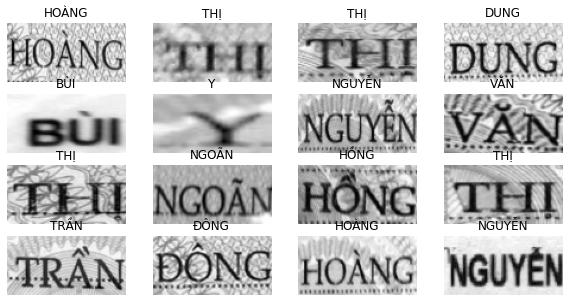

In [43]:
_, ax = plt.subplots(4, 4, figsize=(10,5))
print(train_dataset.take(1))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        label = label.replace(NULL_CHAR, "")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [44]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
 
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
 
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
 
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
 
        # At test time, just return the computed predictions
        return y_pred
 
 
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
 
    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
 
    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
 
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
 
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
 
    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
 
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)
 
    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model
 
 
# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 100, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 100, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 50, 25, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 50, 25, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

In [ ]:

epochs = 100
early_stopping_patience = 10
# Add early stoppingima
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
print(train_dataset)
print(validation_dataset)
print(early_stopping)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

<PrefetchDataset shapes: {image: (None, 100, 50, 1), label: (None, 7)}, types: {image: tf.float32, label: tf.int64}>
<PrefetchDataset shapes: {image: (None, 100, 50, 1), label: (None, 7)}, types: {image: tf.float32, label: tf.int64}>
Epoch 1/100
39/39 [==============================] - 19s 209ms/step - loss: 37.1693 - val_loss: 14.6189
Epoch 2/100
39/39 [==============================] - 7s 192ms/step - loss: 14.2511 - val_loss: 14.1754
Epoch 3/100
39/39 [==============================] - 7s 177ms/step - loss: 13.8404 - val_loss: 13.8832
Epoch 4/100
39/39 [==============================] - 7s 177ms/step - loss: 13.5538 - val_loss: 13.6254
Epoch 5/100
39/39 [==============================] - 7s 170ms/step - loss: 13.3081 - val_loss: 13.3823
Epoch 6/100
39/39 [==============================] - ETA: 0s - loss: 13.0606

In [ ]:
max_length = max([len(label) for label in labels])

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
      
      label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")  
      orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()